In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
from scipy.interpolate import interp1d
from matplotlib.patches import Circle
from scipy.special import gamma
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad, nquad
import matplotlib.patches as patches
from itertools import product
from scipy.integrate import quad
import scipy.optimize as optimize
from  scipy.interpolate import interp1d
from scipy.misc import derivative
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import glob
from unsio import *
import os
import wkbl
from wkbl.astro.halo_info import *
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
from matplotlib.colors import LogNorm
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
from scipy.misc import derivative
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [3]:
hydro = wkbl.astro.halo_info.HALOCHydro()
simname=hydro.name
myhydro = wkbl.Galaxy_Hound(hydro.path)
print myhydro.dm.pos3d[:,0].max()
myhydro.center_shift(hydro.c_dm_com)
myhydro.r_virial(600,n=16)

loading Dark matter..
loading Stars..
loading Gas..
19878.006
| r_200 = 182.23
| Diagonal matrix computed 
|    | 17, 0, 0|
| D =| 0, 12, 0|
|    | 0,  0, 3|


In [4]:
pos_dm = np.array(myhydro.dm.pos3d.reshape(len(myhydro.dm.pos3d)*3),dtype=np.float32)
pos_gs = np.array(myhydro.gs.pos3d.reshape(len(myhydro.gs.pos3d)*3),dtype=np.float32)
pos_st = np.array(myhydro.st.pos3d.reshape(len(myhydro.st.pos3d)*3),dtype=np.float32)
pos = np.concatenate((pos_dm, pos_st, pos_gs))
phi_cord = np.concatenate((myhydro.dm.phi,myhydro.st.phi, myhydro.gs.phi))

mass = np.concatenate((myhydro.dm.mass,myhydro.st.mass,myhydro.gs.mass))
v = np.concatenate((myhydro.dm.v,myhydro.st.v,myhydro.gs.v))
print len(mass)*3, len(pos)
pos3d = pos.reshape(len(pos)/3,3)
r2 = pos3d[:,0]**2 + pos3d[:,1]**2 +pos3d[:,2]**2

155243646 155243646


In [5]:
ok, acc, Phy = CF.getGravity(pos,mass,0.15,G=myhydro.p.G)
Phy = Phy * myhydro.p.kpctokm**2

In [6]:
%%time
sorted_by_r = np.argsort(myhydro.dm.r)
r_sor = myhydro.dm.r[sorted_by_r]
v_sor = myhydro.dm.v[sorted_by_r]

Phi = Phy[:len(myhydro.dm.mass)]
Psi_sor = Phi.max()-Phi[sorted_by_r]
window_size = 3000
block_size =200
mow_Psi= Psi_sor[:window_size]
mow_r = r_sor[:window_size]
print np.mean(mow_r)
Psi_averaged = r_averaged = np.array([])
for i in range(0,len(Psi_sor)/block_size):
    to=i%(window_size/block_size)
    Psi_averaged = np.append(Psi_averaged, np.mean(mow_Psi))
    r_averaged = np.append(r_averaged, np.mean(mow_r))
    mow_Psi[to*block_size:block_size*(to+1)] = Psi_sor[i*block_size:block_size*(i+1)]
    mow_r[to*block_size:block_size*(to+1)] = r_sor[i*block_size:block_size*(i+1)]   

1.0587911416865279
CPU times: user 3.88 s, sys: 636 ms, total: 4.51 s
Wall time: 7.25 s


In [7]:
# Get a function to interpolate date
f = interp1d(r_averaged,Psi_averaged)

# Get a function that evaluates the derivative of the linear spline at any x 
# while looping on the possible values to begin that does not fall bellow interpolation range
done =False 
cutted = 1
while done==False:
    try:
        dfdx = derivative(f,r_averaged[cutted:-cutted])
        done = True
    except:
        cutted+=1
print r_averaged[cutted]
cutted*=3
dfdx = derivative(f,r_averaged[cutted:-cutted])
# Evaluate the derivative dydx at each x location...



2.0606083999506537


In [8]:
r_sor[0]

2909.5501967640025

In [9]:
%%latex
first we define the positive-definite relative gravitational potential
\begin{equation}
\Psi(r) = \Phi_0 -\Phi(r)
\end{equation}
we have a this value for each dark matter particle in the simulation. A moving window average is ran over the sorted data set of $\Psi(r)$ 
and then an interpolation of its result builds a function that can therefore be numerically differenciated with respect to r.

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


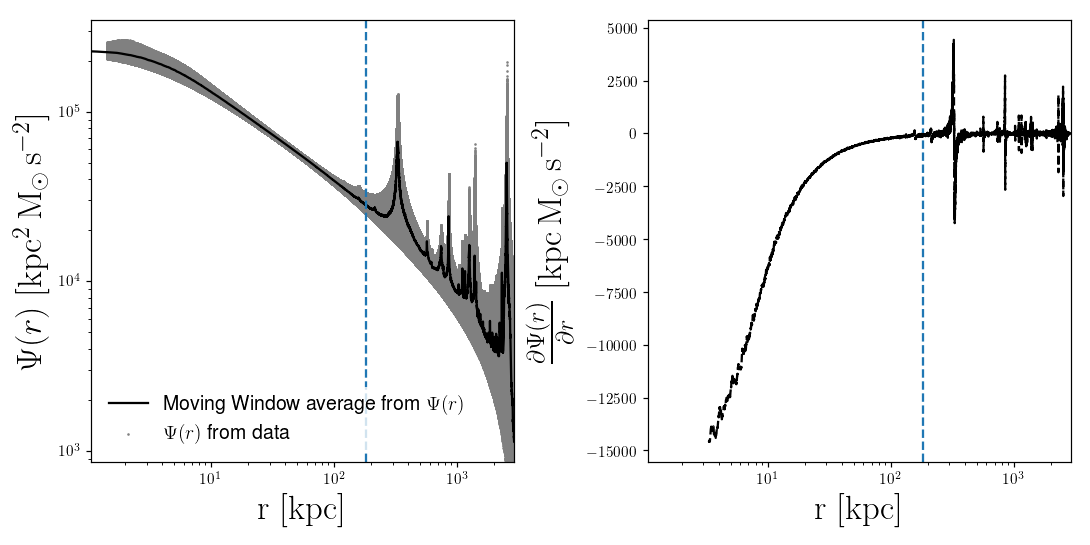

In [11]:
fig, [ax,ax1] = plt.subplots(1,2,figsize=[10,5])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([r_averaged.min(),r_averaged.max()])
ax1.set_xlim([r_averaged.min(),r_averaged.max()])

ax.scatter(r_sor,Psi_sor,s=.5,color='gray',label=r"$\Psi(r)$ from data")
ax.plot(r_averaged,Psi_averaged,c='k',label=r"Moving Window average from $\Psi(r)$")
ax.set_xlabel(r'$\mathrm{r \;[kpc]}$', fontsize=23)
ax.set_ylabel(r'$\Psi(r)\mathrm{\;[kpc^2 \,M_{\odot}\, s^{-2}]}$', fontsize=23)


ax.axvline(x=myhydro.r200, linestyle='--')
leg = ax.legend(loc='lower left', ncol=1, shadow=False, fontsize=13)
leg.get_frame().set_linewidth(0.0)

ax1.set_xscale('log')
ax1.axvline(x=myhydro.r200, linestyle='--')

ax1.plot(r_averaged[cutted:-cutted],dfdx,'k--')
ax1.set_xlabel('$\mathrm{r \;[kpc]}$', fontsize=23)
ax1.set_ylabel(r'$\frac{\partial\Psi(r)}{\partial r}\mathrm{\;[kpc \,M_{\odot}\, s^{-2}]}$', fontsize=23)
plt.tight_layout()



In [11]:
%%latex
now we define the relative energy per particle $\mathcal{E}$ as 
\begin{equation}
\mathcal{E} = \Psi(r) - \frac{v^2}{2}
\end{equation}
and the distribution of particles in $\mathcal{E}\equiv\frac{\text{dN}}{\text{d}\mathcal{E}}$  as the number of particle belinging to a set of intervals $i$
where each particle is weighted by $\omega_i$:
\begin{equation}
 \omega_i = \frac{-1}{(4\pi)^2 r_i^2 v_i}
\end{equation}
which leads to the definition of the energy distribution $f(\mathcal{E})$ as:
\begin{equation}
 f(\mathcal{E}) = \frac{\text{dN}}{\text{d}^3\vec{r}\, \text{d}^3\vec{v}}=\frac{-1}{(4\pi)^2 r_i^2 v_i \Delta\mathcal{E}} \frac{\partial \Psi}{\partial r} \frac{\text{dN}}{\text{d}\mathcal{E}}
\end{equation}
where $\Delta\mathcal{E}$ is the width of the correspondent bin

<IPython.core.display.Latex object>

In [12]:
fil = glob.glob("/home/arturo/Documents/LAM/LAM2LUPM/f_of_E/"+hydro.namenospace+"/fE_Eddington_"+hydro.namenospace+"_DM_baryons_*")
f_E_Theory = np.loadtxt(fil[0])
f_E_Theory[:,0]

array([2.42762607e-11, 2.92963529e-11, 3.53545510e-11, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

In [13]:
sorted_by_r = np.argsort(myhydro.dm.r)
r_sor = myhydro.dm.r[sorted_by_r]
v_sor = myhydro.dm.v[sorted_by_r]

inside = np.where((r_sor>r_averaged[cutted])&(r_sor<r_averaged[-cutted]))
#making and equidistant array
part_per_bin = 1000
N_total = len(r_sor[inside])


##
dfdx_particle = derivative(f,r_sor[inside])
ep_sor = Psi_sor[inside] - (v_sor[inside]**2)/2.
ep_tmp = ep_sor[np.argsort(ep_sor)]
ep_tmp = ep_tmp[ep_tmp>0]
equi_bins = ep_tmp[range(0,len(ep_tmp),5000)]
bin_num = 300
bins = np.linspace(0,ep_sor.max(),bin_num)

w = -dfdx_particle/((4.*np.pi)**2) / (r_sor[inside]**2) / (v_sor[inside])
dNdE, E = np.histogram(ep_sor,bins=equi_bins,weights=w)
dNdE2, E2 = np.histogram(ep_sor,bins=bins,weights=w)

E_width = E[1:]-E[:-1]
E_center = (E[1:]+E[:-1])/2.

E_width2 = E2[1:]-E2[:-1]
E_center2 = (E2[1:]+E2[:-1])/2.


<IPython.core.display.Javascript object>


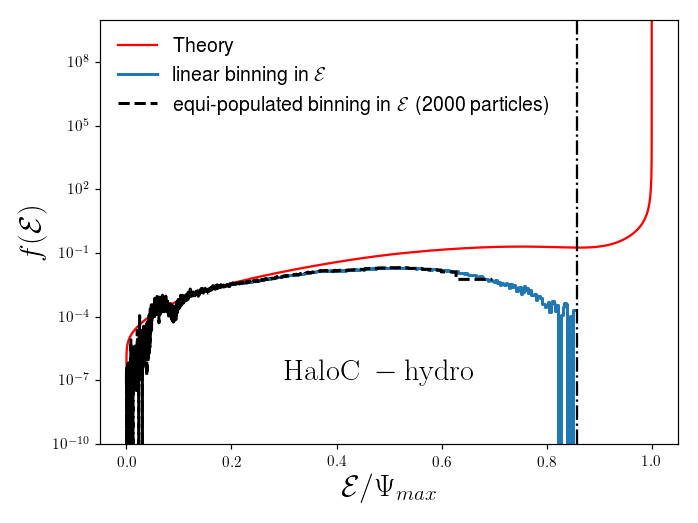

In [14]:
fig, ax = plt.subplots()
ax.plot(f_E_Theory[:,0],f_E_Theory[:,1],'r', label='Theory')
ax.set_yscale('log')
ax.set_ylim([1e-10,1e10])
ax.step( E_center2 / Psi_sor.max(),dNdE2/ E_width2 ,linewidth=2,label=r"linear binning in $\mathcal{E}$")
ax.step( E_center / Psi_sor.max(),dNdE/ E_width ,color='k',linestyle='--',linewidth=2,label=r"equi-populated binning in $\mathcal{E}$ (2000 particles)")
ax.set_xlabel(r'$\mathcal{E}/ \Psi_{max}$',fontsize=20)
ax.set_ylabel(r'$f(\mathcal{E}) $',fontsize=20)
leg = ax.legend(loc='upper left', ncol=1, shadow=False, fontsize=13)
leg.get_frame().set_linewidth(0.0)
diff = np.abs(r_averaged- 3*myhydro.gs.hsml.min())
ax.axvline(x=Psi_averaged[(diff == diff.min()) ][0]/ Psi_sor.max(),c='k',ls='-.')
ax.text(0.3,1e-7,r"$\rm "+hydro.name+"\;-"+hydro.version+"$",fontsize=20)
fig.tight_layout()

In [261]:
diff = np.abs(r_averaged- myhydro.gs.hsml.min())
print Psi_averaged[(diff == diff.min()) ][0]/ Psi_sor.max()

0.9445815915459407


In [65]:
dfds

In [3]:
mpl.__version__

'2.2.3'

In [2]:
import numpy as np
np.__version__

'1.15.2'

In [9]:
import platform
platform.python_version()

'3.5.2'